# Representation and Model Comparison

Using MIDI input, compare different distributional assumptions in the hidden and observed state spaces to explore differences.

1. Discrete Observations, Discrete State Space - Regular Baum-Welch
2. Continous Observations, Discrete State Space - Modified Baum-Welch
3. Continous Observations, Continuous State Space - Kalman Filter
4. Discrete Observations, Discrete State Space - Dilated Convolutions (lag-1)

In [41]:
import numpy as np
import pandas as pd
import csv
from numpy import linspace,exp
from numpy.random import randn
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
import seaborn as sns

import scipy 
import editdistance
import sklearn.metrics
import statsmodels.api as sm

%matplotlib inline 
np.random.seed(17)

## Algorithmic Composition Functions

In [42]:
## Helper functions for working with note pitch representation

## Convert from pitch representation (integers 0-127) to integers (0-max)
## x is the input vector of notes and code is a vector of the unique pitches in x
def encode(x, code):
    output = np.array([int(np.where(code == x[i])[0]) for i in range(0, len(x))])
    return output


## Reverses the function encode
## x is the vector of pitches to decode and code is a vector of the unique pitches in x before it was encoded
def decode(x, code):
    output = np.zeros(len(x))
    for i in range(0, len(x)):
        output[i] = code[x[i]]
    return output

## Function to convert the values in array to the nearest values in the array value
## Used to convert continues TVAR generated pitches to closest integer values for MIDI representation
def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return array[idx]

In [43]:
## Function to pre-process input CSV of original song into form that can be used for modeling and metrics
## Assumes original piece's MIDI file has been converted to a CSV using http://www.fourmilab.ch/webtools/midicsv/#midicsv.5
## input_filename = name of original csv
## output_filename = name of new csv to save generated piece to
## Outputs:
##         quarter_note = number of time steps corresponding to 1 quarter note
##         num = numerator in key signature
##         denom = denominator in key signature
##         key = key signature of piece, integer between -7 and 7 where 0 is C Major
##         measures = number of measures in input piece
##         time = vector of time stamps at which notes occurr
##         notes = vector of note pitches (integers 0-127)
##         velocity = "volume" of each note pitch, 0 = note off, length of time is the same as length of notes and velocity
##         song = pandas dataframe to use for output generated pieces, retains formatting expected by MIDI-CSV
##         song.index = index of original song dataframe

## See http://www.fourmilab.ch/webtools/midicsv/#midicsv.5 for a discussion of MIDI and CSV formats

class pre_process(object):
    def __init__(self, input_filename, min_note):
        self.input_filename = input_filename
        self.min_note = min_note
      
    
    def read_process(self):
        with open(self.input_filename,encoding = "ISO-8859-1") as fd:
            reader=csv.reader(fd)
            rows= [row for idx, row in enumerate(reader)]
        song = pd.DataFrame(rows)
        r,c = np.where(song == ' Header')
        quarter_note = song.iloc[r,5].values.astype(int)[0]
        r, c = np.where(song == ' Time_signature')
        num = song.iloc[r, 3].values.astype(int)[0]
        denom = song.iloc[r, 4].values.astype(int)[0]**2
        try:
            r, c = np.where(song == ' Key_signature')
            key = song.iloc[r,3].values.astype(int)[0]
        except:
            key = None
        
        song_model = song.loc[song.iloc[:,0] == np.max(song.iloc[:,0])]
        song_model = song_model[song_model.iloc[:, 2].isin([' Note_on_c', ' Note_off_c'])]
        time = np.array(song_model.iloc[:,1]).astype(int)
        notes = np.array(song_model.iloc[:,4]).astype(int)
        velocity = np.array(song_model.iloc[:,5]).astype(int)
        measures = np.round(np.max(time)/quarter_note)/num
        min_note = quarter_note
        actual = np.arange(0, min_note*measures*num, min_note).astype(int) 
        time2 = np.array([find_nearest(actual, time[i]) for i in range(len(time))]).astype(int)
        return(quarter_note, num, denom, key, measures, time, time2, notes, velocity, song, song_model.index)
    
    
## newNotes = vector of note pitches of new, generated piece
## velocity = velocity of original piece
## newVelocities = velocities for newNotes, with 0s appropriately filled in and spline values for other non-0 values

def find_vel(newNotes, velocity):
    # Use splines to interpolate the velocities
    newVelocities = np.zeros(len(newNotes))
    y = velocity[np.nonzero(velocity)]
    indicies = []
    for i in np.unique(newNotes):
        indicies.append(np.where(newNotes == i)[0][::2])  ## set every other pitch occurrence to 0 (turn off)

    unlist = [item for sublist in indicies for item in sublist]
    unlist.sort()
    X = np.array(range(0,len(y)))
    s = UnivariateSpline(X, y, s=300) #750
    xs = np.linspace(0, len(y), len(unlist), endpoint = True)
    ys = s(xs)    
    newVelocities[np.array(unlist)] = np.round(ys).astype(int)
    #Fix entries that are too small or too large due to spline overfitting
    newVelocities[np.where(newVelocities < 0)[0]] = y[-1]
    newVelocities = newVelocities.astype(int)    

    return(newVelocities)

In [8]:
quarter_note, num, denom, key, measures, time_piece, time_metrics, \
            notes, velocity, song, ind = pre_process('OriginalCSV/pachelbel.csv', 64).read_process()
    #Find possible unique notes and velocities
possibleNotes = np.unique(notes)
possibleVelocities =  np.unique(velocity)

P = len(possibleNotes)
xNotes = encode(notes, possibleNotes)
T = len(xNotes)

x = xNotes
## Encode and scale notes
y = (xNotes - np.mean(xNotes))/np.std(xNotes)

print(x[:10])
y[0:10]

[13 15  6 13 15 12 14  6  3 12]


array([ 0.05232213,  0.35418057, -1.00418242,  0.05232213,  0.35418057,
       -0.09860709,  0.20325135, -1.00418242, -1.45697008, -0.09860709])

## 1. Hidden Markov Models - Discrete State Space, Discrete Observations

In [44]:
#Function using the log-sum-exp trick#
def logSumExp(a):
    if np.all(np.isinf(a)):
        return np.log(0)
    else:
        b = np.max(a)
        return(b + np.log(np.sum(np.exp(a-b))))
def pForward(g, x):
    pXf = logSumExp(g[len(x)-1,:])
    return(pXf)
def indicator(a, b):
    if a == b:
        return 1
    else:
        return 0

In [45]:
def forwardAlg_Discrete(n, m, k, pi, Tmat, phi, x):
    g = np.zeros((n,m))
    for i in range(0,m):
        g[0,i] = (pi[i]) + (phi[i, x[0]])
    
    for j in range(1, n):
        for l in range(0, m):
            g[j,l] = logSumExp(np.asarray(g[j-1, :])+np.asarray(Tmat[:,l])+(phi[l,x[j]]))
    return(g)

def backwardAlg_Discrete(n, m, k, pi, Tmat, phi, x):
    r = np.zeros((n,m))
    for j in range(n-2, -1, -1):
        for l in range(0, m):
            r[j, l] = logSumExp(np.asarray(r[j+1,: ]) + np.asarray(Tmat[l,:]) + phi[:, x[j+1]])
    return(r)

def Viterbi(n, m, k, pi, Tmat, phi, x):
    f = np.zeros(shape = (n,m))
    alpha = np.zeros(shape = (n,m))
    zStar = np.zeros(n)
    
    for t in range(0, n):
        for i in range(0,m):
            if t == 0:
                f[0, i] = pi[i] + phi[i, x[0]]
            else:
                u = np.asarray(f[t-1, :]) + np.asarray(Tmat[:, i]) + phi[i, x[t]]
                f[t,i] = np.max(u)
                alpha[t,i] = np.argmax(u)
    zStar[n-1] = np.argmax(np.asarray(f[n-1, :]))
    for i in range(n-2, -1, -1):
        zStar[i] = alpha[i+1, int(zStar[i+1])]
    return zStar

In [46]:
def HMM_Discrete(n, m, k, x, tol):
    #randomly initialize pi, phi and T#
    vals = np.random.rand(m)
    pi = np.log(vals/np.sum(vals))
    Tmat = np.zeros(shape = (m, m))
    phi = np.zeros(shape = (m, k))
    gamma = np.zeros(shape = (n, m))
    beta = np.zeros(shape = (n,m,m))
    iterations = 0
    convergence = 0
    count = 0
    pOld = 1E10
    pNew = 0
    criteria = 0
    #cdef double[:,:] p = np.zeros(shape = (n,m))
    
    vals1 = np.random.rand(m,m)
    vals2 = np.random.rand(m,k)
    Tmat = np.log(vals1/np.sum(vals1, axis=1)[:,None])
    phi = np.log(vals2/np.sum(vals2, axis = 1)[:,None])
    
    
    #Stop iterations when log(p(x_1:n)) differs by tol between iterations#
    while convergence == 0:
        #Perform forward and backward algorithms# 
        g = forwardAlg_Discrete(n, m, k, pi, Tmat, phi, x)
        h = backwardAlg_Discrete(n, m, k, pi, Tmat, phi, x)
        pNew = pForward(g, x)
        
        ##E-Step##
    
        #Calculate gamma and beta#
        for t in range(0, n):
            for i in range(0,m):
                gamma[t,i] = g[t,i] + h[t,i] - pNew
        #p = np.full((n,m), pNew)
        #gamma = g+h-p
        for t in range(1, n):
            for i in range(0, m):
                for j in range(0, m):
                    beta[t,i,j] = Tmat[i,j] + phi[j, x[t]] + g[t-1, i] + h[t, j] - pNew
        ##M-Step##
    
        #Update pi, phi and Tmat#
        pi = gamma[0,:] - logSumExp(gamma[0,:])
        for i in range(0, m):
            for j in range(0, m):
                Tmat[i,j] = logSumExp(beta[1::, i, j]) - logSumExp(beta[1::, i,:])
        
        for i in range(0,m):
            for w in range(0, k):
                j = 0
                count = 0
                for t in range(0,n):
                    if x[t] == w:
                        count = count+1
                indicies = np.zeros(count)
                for t in range(0,n):
                    if x[t] == w:
                        indicies[j] = gamma[t,i]
                        j = j+1
                    
                phi[i,w] = logSumExp(indicies) - logSumExp(gamma[:,i])
        
        criteria = abs(pOld - pNew)
        if criteria < tol:
            convergence = 1
        
        elif iterations > 1000:
            convergence = 1
        else:
            convergence = 0
            pOld = pNew
            iterations +=1
            if iterations%50 == 0:
                print(iterations)
    return (iterations, pNew, np.exp(pi), np.exp(phi), np.exp(Tmat))

In [26]:
discrete = HMM_Discrete(T, 3, P, x, 0.1)

50


In [47]:
## Function to generate new pieces from the HMM, 2-HMM, 3-HMM, LR-HMM, 2LR-HMM, and 3-LR HMM
## n is the length of the original and generated piece
## pi is the learned initial distribution
## phi is the learned emission distribution
## Tmat is the learned transition matrix
## T2mat is the learned second order transition matrix (if applicable)
## T3mat is the learned third order transition matrix (if applicable)
## code is the unique note pitches occurring in the original piece
## model is the model order which the input parameters correspond to, either "first_order", "second_order" or "third_order"
## Outputs: output is the note pitches of the generated pieces (array of length n), z are the generated hidden states 
##          (vector of length n)
def genHMM_Discrete(n, pi, phi, Tmat):
    m = Tmat.shape[0]
    k = phi.shape[1]
    zstates = np.arange(0, m, dtype = int)
    xstates = np.arange(0, k, dtype = int)
    z = np.zeros(n, dtype = int)
    x = np.zeros(n, dtype = int)
    z[0] = np.random.choice(zstates, size = 1, p = pi)
    for j in range(1, n):
        z[j] = np.random.choice(zstates, size = 1, p = Tmat[z[j-1], :])
    for i in range(0, n):
        x[i] = np.random.choice(xstates, size = 1, p = phi[z[i], :])
    return (x, z)

In [28]:
x_Discrete = genHMM_Discrete(T, discrete[2], discrete[3], discrete[4])
output = decode(x, possibleNotes)

In [29]:
output

array([62., 66., 50., ..., 62., 38., 50.])

## 2. Hidden Markov Models - Discrete State Space, Continuous Observations


$$\phi_j(x) = p(x | Z = j) = N(x | \mu_j, \Sigma_j)$$
$$\hat{\mu}_j = \dfrac{\sum_{t=1}^T \gamma_t(j)x_t}{\sum_{t=1}^T \gamma_t(j)}$$
$$\hat{\Sigma}_j = \dfrac{\sum_{t=1}^T \gamma_t(j) (x_t - \hat{\mu}_j)(x_t - \hat{\mu}_j)^T}{\sum_{t=1}^T \gamma_t(j)}$$

https://www.inf.ed.ac.uk/teaching/courses/asr/2016-17/asr03-hmmgmm-handout.pdf

In [48]:
def forwardAlg_Continuous(n, m, pi, Tmat, mu, Sigma, x):
    g = np.zeros((n,m))
    for i in range(0,m):
        g[0,i] = (pi[i]) + np.log(scipy.stats.norm(loc=mu[i], scale=np.sqrt(Sigma[i])).pdf(x[0]))
    
    for j in range(1, n):
        for l in range(0, m):
            g[j,l] = logSumExp(np.asarray(g[j-1, :])+np.asarray(Tmat[:,l])+\
                               (np.log(scipy.stats.norm(loc=mu[l], scale=np.sqrt(Sigma[l])).pdf(x[j]))))
    return(g)


def backwardAlg_Continuous(n, m, pi, Tmat, mu, Sigma, x):
    r = np.zeros((n,m))
    for j in range(n-2, -1, -1):
        for l in range(0, m):
            r[j, l] = logSumExp(np.asarray(r[j+1,: ]) + np.asarray(Tmat[l,:]) + \
                                np.log(scipy.stats.norm(loc=mu, scale=np.sqrt(Sigma)).pdf(x[j+1])))
                                
    return(r)

In [49]:
def HMM_Continuous(n, m, x, tol):
    #randomly initialize pi, phi and T#
    vals = np.random.rand(m)
    pi = np.log(vals/np.sum(vals))
    Tmat = np.zeros(shape = (m, m))
    mu = np.zeros(shape = m)
    Sigma = np.ones(shape = m)
    gamma = np.zeros(shape = (n, m))
    beta = np.zeros(shape = (n,m,m))
    iterations = 0
    convergence = 0
    count = 0
    pOld = 1E10
    pNew = 0
    criteria = 0
    #cdef double[:,:] p = np.zeros(shape = (n,m))
    
    vals1 = np.random.rand(m,m)
    Tmat = np.log(vals1/np.sum(vals1, axis=1)[:,None])
    
    
    #Stop iterations when log(p(x_1:n)) differs by tol between iterations#
    while convergence == 0:
        #Perform forward and backward algorithms# 
        g = forwardAlg_Continuous(n, m, pi, Tmat, mu, Sigma, x)
        h = backwardAlg_Continuous(n, m, pi, Tmat, mu, Sigma, x)
        pNew = pForward(g, x)
        
        ##E-Step##
    
        #Calculate gamma and beta#
        for t in range(0, n):
            for i in range(0,m):
                gamma[t,i] = g[t,i] + h[t,i] - pNew
        #p = np.full((n,m), pNew)
        #gamma = g+h-p
        for t in range(1, n):
            for i in range(0, m):
                for j in range(0, m):
                    beta[t,i,j] = Tmat[i,j] + g[t-1, i] + h[t, j] +\
                    np.log(scipy.stats.norm(loc=mu[j], scale=np.sqrt(Sigma[j])).pdf(x[t])) - pNew
        ##M-Step##
    
        #Update pi, phi and Tmat#
        pi = gamma[0,:] - logSumExp(gamma[0,:])
        for i in range(0, m):
            for j in range(0, m):
                Tmat[i,j] = logSumExp(beta[1::, i, j]) - logSumExp(beta[1::, i,:])
        
        for i in range(0,m):
            mu[i] = np.sum(np.exp(gamma[:,i])*x)/np.sum(np.exp(gamma[:, i]))
            
            Sigma[i] = np.sum(np.exp(gamma[:, i])*(x-mu[i])**2)/np.sum(np.exp(gamma[:, i]))
            
        
        criteria = abs(pOld - pNew)
        if criteria < tol:
            convergence = 1
        
        elif iterations > 1000:
            convergence = 1
        else:
            convergence = 0
            pOld = pNew
            iterations +=1
            if iterations%50 == 0:
                print(iterations)
    return (iterations, pNew, np.exp(pi), mu, Sigma, np.exp(Tmat))

In [66]:
continuous = HMM_Continuous(T, 3, y, 0.1)

In [50]:
def genHMM_Continuous(n, pi, mu, Sigma, Tmat):
    m = Tmat.shape[0]
    zstates = np.arange(0, m, dtype = int)
    z = np.zeros(n, dtype = int)
    x = np.zeros(n)
    z[0] = np.random.choice(zstates, size = 1, p = pi)
    for j in range(1, n):
        z[j] = np.random.choice(zstates, size = 1, p = Tmat[z[j-1], :])
    for i in range(0, n):
        x[i] = scipy.stats.norm(loc=mu[z[i]], scale=np.sqrt(Sigma[z[i]])).rvs()  
    return (x, z)

In [75]:
newY = genHMM_Continuous(T, continuous[2], continuous[3], continuous[4], continuous[5])
newY

(array([ 0.78930082,  0.53998504,  0.20229038, ..., -0.52185279,
         0.63635934,  0.47788733]), array([0, 0, 2, ..., 1, 1, 2]))

## 3. Kalman Filter - Continuous State Space, Continuous Observations

$$p(z_1) = N(z_1 | \mu_0, V_0)$$
$$p(z_t | z_{t-1}) = N(z_t | Fz_{t-1}, Q)$$
$$p(x_t | z_t) = N(x_t | Hz_t, R)$$

### Forward Filter

1. Initialize

$$K_1 = V_0H^T(HV_0H^T + R)^{-1}$$
$$\mu_1 = \mu_0 + K_1(x_1 - H\mu_0)$$
$$V_1 = (I-K_1H)V_0$$
$$P_1 = FV_1F^T + Q$$

2. For t = 2, 3, ..., T

$$K_t = P_{t-1}H^T(HP_{t-1}H^T + R)^{-1}$$
$$\mu_t = F\mu_{t-1} + K_t(x_t - HF\mu_{t-1})$$
$$V_t = (I - K_tH)P_{t-1}$$
$$P_t = FV_tF + Q$$


### Backwards Sampler

1. Initialize

$$\hat{\mu}_T = \mu_T$$
$$\hat{V}_T = V_T$$

2. For t = T-1, T-2, ..., 2, 1

$$C_t = V_tF^TP_t^{-1}$$
$$\hat{\mu}_t = \mu_t + C_t(\hat{\mu}_{t+1} - F\mu_t)$$
$$\hat{V}_t = V_t + C_t (\hat{V}_{t+1} - P_t)C_t^T$$



$$p(z_t | x_{1:T}) = N(z_t | \hat{\mu}_t, \hat{V}_t)$$

In [51]:
def FFBS(x, mu0, V0, F, Q, H, R):
    T = len(x)
    mu = np.zeros(T)
    V = np.zeros(T)
    P = np.zeros(T)
    C = np.zeros(T)
    mu_hat = np.zeros(T)
    V_hat = np.zeros(T)
    
    ## Forward Filter
    K = (V0*H)/(H*V0*H+R)
    mu[0] = mu0 + K*(x[0] -H*mu0)
    V[0] = (1-K*H)*V0
    P[0] = F*V[0]*F + Q
    for t in range(1, T):
        K = (P[t-1]*H)/(H*P[t-1]*H + R)
        mu[t] = F*mu[t-1] + K*(x[t] - H*F*mu[t-1])
        V[t] = (1-K*H)*P[t-1]
        P[t] = F*V[t]*F + Q
        
    ## Backwards Sampler
    mu_hat[T-1] = mu[T-1]
    V_hat[T-1] = V[T-1]
    C[T-1] = V[T-1]*F*1/P[T-1]
    for t in range(T-2, -1, -1):
        C[t] = V[t]*F*1/P[t]
        mu_hat[t] = mu[t] + C[t]*(mu_hat[t+1] - F*mu[t])
        V_hat[t] = V[t] + C[t]*(V_hat[t+1] - P[t])*C[t]
        
    return(mu_hat, V_hat, C)

In [8]:
test = np.arange(4)
print(test)
test[:-1]

[0 1 2 3]


array([0, 1, 2])

In [52]:
def Kalman_Filter(x, a, b, it):
    ## it = number of Gibbs iterations
    T = len(x)
    F = np.zeros(it)
    H = np.zeros(it)
    Q = np.zeros(it)
    R = np.zeros(it)
    sigmaF = np.zeros(it)
    sigmaH = np.zeros(it)
    
    Q[0] = 1
    R[0] = 1
    sigmaF[0] = 0.5
    sigmaH[0] = 1
    mu0 = 0
    V0 = np.std(x)
    
    for t in range(1, it):
        ## FFBS - conditional distribution for z
        mu_hat, V_hat, _ = FFBS(x, mu0, V0, F[t-1], Q[t-1], H[t-1], R[t-1])
        z = scipy.stats.norm(loc=mu_hat, scale=np.sqrt(V_hat)).rvs()
        
        ## Update mu0
        VM = 1/(1/5 + 1/V0)
        muM = 1/V0*VM*z[0]
        mu0 = scipy.stats.norm(loc=muM, scale=np.sqrt(VM)).rvs()
        
        
        
        ## Update F
        VF = 1/(1/sigmaF[t-1] + 1/Q[t-1]*np.sum(z[:-1]**2))
        muF = 1/Q[t-1]*VF*np.sum(z[1:]*z[:-1])
#         F[t] = scipy.stats.norm(loc=muF, scale=np.sqrt(VF)).rvs()
        F[t] = scipy.stats.truncnorm.rvs((-0.9999-muF)/np.sqrt(VF), (0.9999-muF)/np.sqrt(VF), 
                                  muF, np.sqrt(VF))
        
        
        
        
        ## Update H
        VH = 1/(1/sigmaH[t-1] + 1/R[t-1]*np.sum(z**2))
        muH = 1/R[t-1]*VH*np.sum(z*x)
        H[t] = scipy.stats.norm(loc=muH, scale=np.sqrt(VH)).rvs()
#         H[t] = scipy.stats.truncnorm.rvs((-0.9999-muH)/np.sqrt(VH), (0.9999-muH)/np.sqrt(VH), 
#                                   muH, np.sqrt(VH))
        
        ## Update Q
        Qrate = b + 1/2*np.sum((z[1:] - F[t]*z[:-1])**2)
        Q[t] = 1/np.random.gamma(shape = a+(T-1)/2, scale = 1/Qrate)
        
        ## Update R
        Rrate = b + 1/2*np.sum((x - H[t]*z)**2)
        R[t] = 1/np.random.gamma(shape = a+T/2, scale = 1/Rrate)
        
        ## Update Hyper-Parameters
        sigmaF[t] = 0.5#1/np.random.gamma(shape = a+0.5, scale = 1/(0.5 + F[t]**2))
        sigmaH[t] = 1#1/np.random.gamma(shape = a+0.5, scale = 1/(0.5 + H[t]**2))
        
        if t%100 == 0:
            print(t)
    return(F, H, Q, R, sigmaF, sigmaH)
    

In [53]:
def Kalman_FilterML(x, tol):
    ## it = number of Gibbs iterations
    T = len(x)
    F = -0.1
    H = -0.1
    Q = 1
    R = 1
    mu0 = 0
    V0 = 1
     
    iterations = 0
    convergence = 0
    count = 0
    pOld = 1E10
    pNew = 0
    criteria = 0
    
    #Stop iterations when log(p(x_1:n)) differs by tol between iterations#
    while convergence == 0:
#         print(iterations, F)
        #Perform Kalman Filter# 
        ## FFBS - conditional distribution for z
        mu_hat, V_hat, C = FFBS(x, mu0, V0, F, Q, H, R)

        ##E-Step##
        E1 = np.array([C[t-1]*V_hat[t] + mu_hat[t]*mu_hat[t-1] for t in range(1, T)])
        E2 = np.array([V_hat[t] + mu_hat[t]*mu_hat[t] for t in range(T)])

        
        ##M-Step##
        mu0 = mu_hat[0]
        V0 = E2[0] - mu_hat[0]*mu_hat[0]
        
        F = np.sum(E1)/np.sum(E2[:(T-1)])
        Q = 1/(T-1)*(np.sum(E2[1:]) - 2*F*np.sum(E1) + F*np.sum(E2[:(T-1)])*F)
        
        H = np.sum(x*mu_hat)/np.sum(E2)
        R = 1/T*(np.sum(x*x) - 2*H*np.sum(x*mu_hat) + H*np.sum(E2)*H)
    
        
        pNew = F
        
        criteria = abs(pOld - pNew)
        if criteria < tol:
            convergence = 1
        
        elif iterations > 1000:
            convergence = 1
        else:
            convergence = 0
            pOld = pNew
            iterations +=1
            if iterations%50 == 0:
                print(iterations)
    return(mu0, V0, F, H, Q, R)
    

In [15]:
cont = Kalman_Filter(y, 5, 0.1, 1000)

100
200
300
400
500
600
700
800
900


In [54]:
def genKF_Continuous(n, mu0, V0, F, H, Q, R):
    z = np.zeros(n)
    x = np.zeros(n)
    z[0] = scipy.stats.norm(loc=mu0, scale=np.sqrt(V0)).rvs()
    for j in range(1, n):
        z[j] = scipy.stats.norm(loc=F*z[j-1], scale=np.sqrt(Q)).rvs()
    for j in range(0, n):
        x[j] = scipy.stats.norm(loc=H*z[j], scale=np.sqrt(R)).rvs()  
    return (x, z)

In [49]:
genCont = genKF_Continuous(T, 0, 0.1, np.mean(cont[0][500:]), np.mean(cont[1][500:]), 
                           np.mean(cont[2][500:]), np.mean(cont[3][500:]))
## Generate test data
# genCont = genKF_Continuous(100, 0, 1, 0.7, 0.7, 0.1, 1)

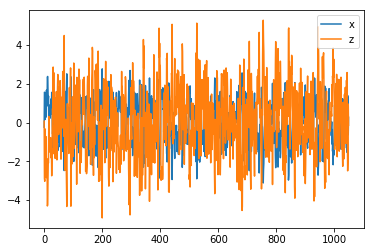

In [50]:
xC, zC = genCont

plt.plot(xC, label = "x")
plt.plot(zC, label = "z")
# plt.plot(y, label = 'y')
plt.legend(loc = "upper right")
pass

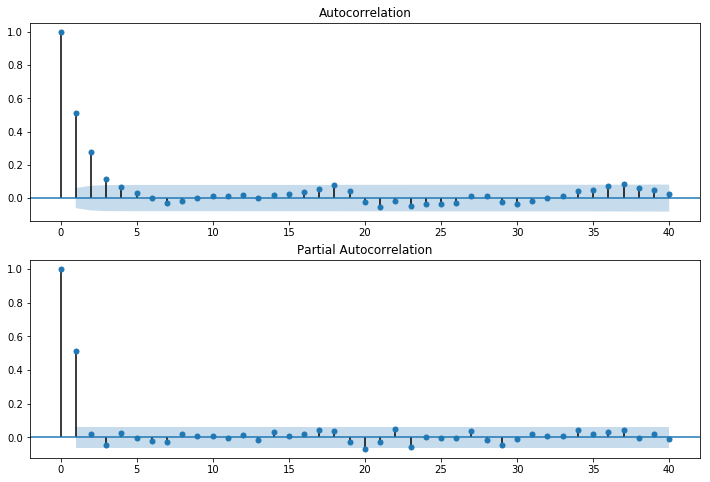

In [51]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(xC, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(xC, lags=40, ax=ax2)

In [622]:
cont = Kalman_FilterML(xC, 0.00001)

0 -0.1
1 -0.09629963740855878
2 -0.09262751264697304
3 -0.08918735652343283
4 -0.08587838948492973
5 -0.08261556409640415
6 -0.07932346570172702
7 -0.075931816442242
8 -0.07237201702986176
9 -0.06857435629101731
10 -0.06446563477299837
11 -0.05996701694853426
12 -0.05499196264069079
13 -0.049444099354219125
14 -0.043214884642907
15 -0.036180868196388626
16 -0.02820028886498495
17 -0.019108618040157174
18 -0.008712464417455166
19 0.0032190507814543368
20 0.016966812718758315
21 0.03288022081209775
22 0.051404890881661724
23 0.07312437076189818
24 0.09882272278302703
25 0.129576148621351
26 0.16687720080353138
27 0.21276510485775063
28 0.2698189698079109
29 0.3405264144098871
30 0.42494895272850514
31 0.5163172010129347
32 0.6000714657540879
33 0.6640923349886362
34 0.707937731895338
35 0.7379522946479077
36 0.7601337617812266
37 0.7781814727067846
38 0.7940205779413634
39 0.8085698123100449
40 0.8222446352915168
41 0.8352268306014091
42 0.8475956172179391
43 0.8593869374354175
44 0.8706

In [623]:
cont

(-3.9131668070861294,
 0.015663963243207846,
 1.0084779983955514,
 -0.09807460944679287,
 0.07966196340030457,
 0.9315711551465515)

In [630]:
test_new = genKF_Continuous(100, cont[0], cont[1], cont[2], cont[3], cont[4], cont[5])

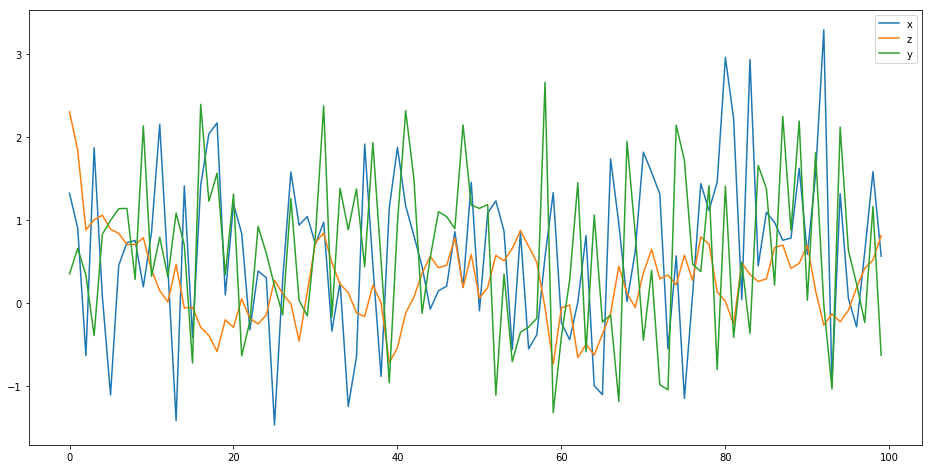

In [631]:
plt.figure(figsize = (16,8))
plt.plot(xC, label = "x")
plt.plot(zC, label = "z")
plt.plot(test_new[0], label = 'y')
plt.legend(loc = "upper right")
pass

## 4. Dilated Convolutions - First Order

#### Author: Karlmayuheng

In [79]:
#the new model
##using log trick
#notations are used as in tutorial
#n is number of length of music
#m is number of different hidden states
#pi is initial distribution
#A is transition matrix
#b is emission matrix
#x is the input vector of notes
#k is the number of possible notes

def forwardDilated(n, m, pi, A, b,b0, x):
    alpha = np.zeros((n,m))
    for i in range(0,m):
        alpha[0,i] =pi[i] +b0[ i, x[0]]
    
    for i in range(1, n):
        for j in range(0, m):
            alpha[i,j] = logSumExp(np.asarray(alpha[i-1, :])+np.asarray(A[:,j])+b[:,j,x[i]])
    return(alpha)
def backwardDilated(n, m, pi, A, b, x):
    beta = np.zeros((n,m))
    
    for t in range(n-2, -1, -1):
        for i in range(0, m):
            beta[t,i] = logSumExp(np.asarray(beta[t+1,: ]) + np.asarray(A[i,:]) + b[i,:, x[t+1]])
    return(beta)
    

def EM_dilated(n, m, k, x, tol):
    #randomly initialize A, b and pi
    pi = np.random.rand(m)
    pi = np.log(pi/np.sum(pi))
    A = np.random.rand(m,m)
    b = np.random.rand(m,m,k)
    b0 = 0.01*np.ones((m,k)) ## apply smoothing
    for i in range(0,m):
        b0[i,x[0]]=1
    gamma = np.zeros((n,m))
    xi = np.zeros((n,m,m))
    iterations = 0
    convergence = 0
    count = 0
    pOld = 1E10
    pNew = 0
    
    
    A = np.log(A/np.sum(A, axis=1)[:,None])
    b = np.log(b/np.sum(b, axis=(0,1))[None,None,:])
    b0= np.log(b0/np.sum(b0, axis=1)[:,None])
    #Stop iterations when log(p(x_1:n)) differs by tol between iterations#
    while convergence == 0:
        #Perform forward and backward algorithms# 
        alpha=forwardDilated(n,m,pi,A,b,b0,x)
        beta=backwardDilated(n,m,pi,A,b,x)
        pNew = logSumExp(alpha[len(x)-1,:])
        
        #Calculate gamma and xi#
        for t in range(0, n):
            for i in range(0,m):
                gamma[t,i] = alpha[t,i] + beta[t,i] - pNew

        for t in range(1, n):
            for i in range(0, m):
                for j in range(0, m):
                    xi[t,i,j] = A[i,j] + b[i,j, x[t]] + alpha[t-1, i] + beta[t, j] - pNew
        
        pi = gamma[0,:] - logSumExp(gamma[0,:])
        for i in range(0, m):
            for j in range(0, m):
                A[i,j] = logSumExp(xi[1::, i, j]) - logSumExp(xi[1::, i,:])
                
                

        for i in range(0,m):
            for j in range(0,m):
                for w in range(0, k):
                    h = 0
                    count = 0
                    for t in range(1,n):
                        if x[t] == w:
                            count = count+1
                    indicies = np.zeros(count)
                    for t in range(1,n):
                        if x[t] == w:
                            indicies[h] = xi[t,i,j]
                            h = h+1
                    b[i,j,w] = logSumExp(indicies) - logSumExp(xi[1::,i,j])
                    
        criteria = abs(pOld-pNew)
        if criteria < tol:
            convergence = 1
        elif iterations > 500:
            convergence = 1
        else:
            convergence = 0
            pOld = pNew
            iterations +=1
            if iterations%50 == 0:
                print(iterations)

    return (np.exp(pi), np.exp(b0) ,np.exp(b), np.exp(A))

In [33]:
p1, b0, b, A = optimize(T, 5, P, x, 0.05)

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in log


-3405.9503099313747
10000003405.95031
1
-3273.821280139731
132.12902979164392
2
-3242.7287908415
31.092489298230703
3
-3194.041076328004
48.6877145134963
4
-3136.421456409377
57.619619918626995
5
-3083.406313499865
53.015142909511724
6
-3040.090193138048
43.31612036181696
7
-3004.151207011967
35.93898612608109
8
-2973.122351520364
31.028855491602826
9
-2946.7068998219456
26.415451698418565
10
-2925.15651930003
21.550380521915486
11
-2908.51939696053
16.637122339500365
12
-2896.080907449069
12.43848951146083
13
-2886.7944078763467
9.286499572722278
14
-2879.7342338452017
7.060174031144925
15
-2873.99073645497
5.743497390231823
16
-2868.92147082068
5.069265634289877
17
-2864.3799166006984
4.541554219981663
18
-2860.481210007567
3.8987065931314646
19
-2857.2144345483084
3.266775459258497
20
-2854.4178170740097
2.7966174742987278
21
-2851.8993162893444
2.5185007846653207
22
-2849.5378281650032
2.361488124341122
23
-2847.317509648132
2.22031851687143
24
-2845.2894864332975
2.028023214834320

In [57]:
def generate_dilated(n,pi,b0,b,A): 
    m = A.shape[0]
    k = b.shape[2]
    xstates=range(0,k)
    zstates=range(0,m)
    z=np.zeros(n,dtype=int)
    x=np.zeros(n,dtype=int)
    z[0]=np.random.choice(zstates,p=pi)
    x[0]=np.random.choice(xstates,p=b0[z[0],:])
    for j in range(1,n):
        z[j]=np.random.choice(zstates,p=A[z[j-1],:])
    for j in range(1,n):
        x[j]=np.random.choice(xstates,p=b[z[j-1],z[j],:])
#     output=decode(o,code,1)
    return (x,z)

In [38]:
new_conv = generate(T,p1,b0,b,A)

In [39]:
new_conv

(array([13, 10,  4, ..., 10, 15, 11]), array([4, 3, 2, ..., 3, 0, 4]))

## 5. Compare via Metrics

### Metrics Functions

In [64]:
## Function to create a matrix of notes and times representing the input piece as a matrix
## time is the time steps (integers) at which a note occurs
## notes are the note pitches (integers 0-127) where each note is "turned on" and "turned off"
## velocity is the note velocity (i.e. volume) at each time step
## measures is the number measures in the original piece
## min_note is the length of the shortest note in the original piece, using same scale as time array above
## num is the number of quarter notes in a measure (i.e. represents the numerator of time signature of the input piece)
## met_mat output is a matrix where columns correspond to the time stamp of notes, one column for each min_note
##    duration for the entire piece and the rows are the note pitches, values in the matrix are 1 for the duration
##    of a note when it is played and 0 when it is not played
def create_matrix(timeT, notes, velocity, measures, min_note, num):
    met_mat = pd.DataFrame(np.zeros(shape = (len(np.unique(notes)), int(measures)*num), dtype = int))
    met_mat.index = np.unique(notes)[::-1]
    met_mat.columns = np.arange(0, min_note*num*measures, min_note)[:int(measures)*num]
    max_time = met_mat.columns[-1]
    for i in np.unique(notes):
        on = timeT[np.intersect1d(np.where(notes == i), np.where(velocity > 0) )]
        off = timeT[np.intersect1d(np.where(notes == i), np.where(velocity == 0) )]
        if len(off) % 2 !=0 or len(on) %2 !=0:
            off = np.append(off, max_time)
        for j in range(len(on)):
            met_mat.loc[i, on[j]:off[j]] = 1
    return(met_mat)

## Function to calculate the musical metrics of generated pieces
## met_mat is the output from create_matrix()
## harmonic ints is a vector of length 12 corresponding to the counts of each type of harmonic interval in the piece considered
## melodic ints is a vector of length 12 corresponding to the counts of each type of melodic interval in the piece considered
## percentage is a vector of length 6 containing the percentage of perfect harmonic intervals, the percentage of imperfect 
##           consonant harmonic intervals, the percentage of dissonant harmonic intervals, the percentage of perfect melodic
##           intervals, the percentage of imperfect consonant melodic intervals and the percentage of dissonant melodic intervals
def musical_metrics(met_mat):
    perfect = np.array([0,5,7])
    imperfect = np.array([3,4,8,9])
    dissonant = np.array([1,2,6,10,11])
    major_scale = np.array([2,2,1,2,2,2,1])
    harmonic_ints = np.zeros(12)
    c = 0
    max_notes = np.max(np.sum(met_mat, axis = 0))
    melodic = np.zeros(shape = (max_notes, len(met_mat.columns)))
    for col in met_mat.columns:
        chord = np.array(met_mat.index[np.where(met_mat[col] == 1)[0]])[::-1]
        if len(chord) > 0:
            intervals = np.diff(chord)
            intervals[intervals >= 12] = intervals[intervals >= 12] % 12
            harmonic_ints[intervals.astype(int)] +=1
            melodic[:len(chord), c] = chord
            c+= 1
    melodic_ints = list()
    for t in range(melodic.shape[1] - 1):
        m1 = melodic[melodic[:,t] > 0, t]
        m2 = melodic[melodic[:,t+1] > 0, t+1]
        melodic_ints.append(np.unique([abs(i-j) %12 for i in m1 for j in m2]))

    u = np.unique(np.hstack(melodic_ints), return_counts=True)
    m_ints = np.zeros(12)
    m_ints[u[0].astype(int)] = u[1].astype(int)

    h_total = np.sum(harmonic_ints)
    m_total = np.sum(m_ints)

    h_per = np.sum(harmonic_ints[perfect])/h_total
    h_imp = np.sum(harmonic_ints[imperfect])/h_total
    h_dis = np.sum(harmonic_ints[dissonant])/h_total

    m_per = np.sum(m_ints[perfect])/m_total
    m_imp = np.sum(m_ints[imperfect])/m_total
    m_dis = np.sum(m_ints[dissonant])/m_total

    percentage = np.array([h_per, h_imp, h_dis, m_per, m_imp, m_dis])

    return(harmonic_ints, m_ints, percentage)

## Calculate the empirical entropy of the input data and output as a vector in entropy
def ent(data):
    p_data= np.unique(data, return_counts = True)[1]/len(data) # calculates the probabilities
    entropy=scipy.stats.entropy(p_data)  # input probabilities to get the entropy 
    return entropy


## Function to compare an original piece to a generated piece and calculate metrics
## old_notes is a vector of the original piece's note pitches
## new_notes is a vector of the generated piece's note pitches
## Returns the empirical entropy, mutual information and edit distance between the original piece and the new, generated piece
##        also returns the count of unique notes in the generated piece, normalized by the total number of notes
def originality_metrics_comparison(old_notes, new_notes):
    # Calculate entropy
    entropy = ent(new_notes)

    # Calculate edit distance
    edit_dist = editdistance.eval(old_notes, new_notes)/len(old_notes)

    # Calculate mutual info
    mutual_info = sklearn.metrics.mutual_info_score(old_notes, new_notes)

    k = len(np.unique(old_notes))
    possibleNotes = np.unique(old_notes)    
    # Calculate note counts
    unique_new_notes, note_counts = np.unique(new_notes, return_counts = True)

    if len(unique_new_notes) != k:
        add_notes = list(set(possibleNotes) - set(unique_new_notes))
        for i in add_notes:
            if np.where(possibleNotes == i)[0] > len(note_counts):
                note_counts = np.append(note_counts, np.where(possibleNotes == i)[0], 0)
            else:
                note_counts = np.insert(note_counts, np.where(possibleNotes == i)[0], 0)
    note_counts = note_counts/len(old_notes)
    return(entropy, mutual_info, edit_dist, note_counts)


## Function to calculate the ACF and PACF out to lag 40
## new_ntoes is the input vector of note pitches
## note_acf is a vector of length 41 of the ACF values and note_pacf is a vector of length 41 of the PACF values
def time_metrics(new_notes):   
    #Calculate ACF/PACF out to lag 40
    note_acf = sm.tsa.stattools.acf(new_notes, fft = True)
    try:
        note_pacf = sm.tsa.stattools.pacf(new_notes)
    except np.linalg.linalg.LinAlgError as err:
        note_pacf = sm.tsa.stattools.pacf(new_notes)

    return(note_acf, note_pacf)


## Function to calculate all metrics
## time is the time steps (integers) at which a note occurs
## notes are the note pitches (integers 0-127) where each note is "turned on" and "turned off"
## velocity is the note velocity (i.e. volume) at each time step
## measures is the number measures in the original piece
## min_note is the length of the shortest note in the original piece, using same scale as time array above
## num is the number of quarter notes in a measure (i.e. represents the numerator of time signature of the input piece)
## output is a vector of the calculated metrics:
##        entropy is the empirical entropy of new_notes
##        mutual_info is the mutual information between old_notes and new_notes
##        edit_dist is the edit distance between old_notes and new_notes
##        harmonic_ints is a vector of length 12 of the count of harmonic intervals of each type in new_notes
##        melodic_ints is a vector of length 12 of the count of melodic intervals of each type in new_notes
##        percentage is a vector of length 6 containing the percentage of perfect harmonic intervals, the percentage of imperfect 
##           consonant harmonic intervals, the percentage of dissonant harmonic intervals, the percentage of perfect melodic
##           intervals, the percentage of imperfect consonant melodic intervals and the percentage of dissonant melodic intervals      
##       note_counts is a vector of length equal to the number of unique pitches in old_notes with a normalized count of pitches
##           in new_notes
##       note_acf is a vector of length 41 with the acf of new_notes
##       note_pacf is a vector of length 41 with the pacf of new_notes
## Note: time is the same for old_notes and new_notes, as this is not changed between the original and generated pieces
##  (likewise, measures, min_note and num are the same for old_notes and new_notes)
def calc_metrics(time, old_notes, new_notes, velocity, measures, min_note, num):
    met_mat = create_matrix(time, new_notes, velocity, measures, min_note, num)
    harmonic_ints, m_ints, percentage = musical_metrics(met_mat)
    entropy, mutual_info, edit_dist, note_counts = originality_metrics_comparison(old_notes, new_notes)
    note_acf, note_pacf = time_metrics(new_notes)
    return(np.hstack((np.array([entropy, mutual_info, edit_dist]), 
           harmonic_ints, m_ints, percentage, note_counts, note_acf, note_pacf)))

In [80]:
def hmm_compose(input_filename, output_filename, min_note, model, m,  tol, it, metrics_calc = False):
    quarter_note, num, denom, key, measures, time_piece, time_metrics, \
            notes, velocity, song, ind = pre_process(input_filename, min_note).read_process()

    #Find possible unique notes and velocities
    #Find possible unique notes and velocities
    possibleNotes = np.unique(notes)
    possibleVelocities =  np.unique(velocity)

    P = len(possibleNotes)
    xNotes = encode(notes, possibleNotes)
    T = len(xNotes)
    
    ## Learn Parameters
    x = (xNotes - np.mean(xNotes))/np.std(xNotes)
    

    if metrics_calc:
        orig_metrics = calc_metrics(time_metrics, notes, notes, velocity, measures, min_note, num)
        metrics = np.zeros(shape = (it+1, len(orig_metrics)))
        metrics[0,:] = orig_metrics
    

    #Run BaumWelch for specified model
    if model == 'discrete':
        it1, p1, pi1, phi1, Tmat1 = HMM_Discrete(T, m, P, xNotes, tol)
        newNotes, z  = genHMM_Discrete(T, pi1, phi1, Tmat1)
        newNotes = decode(newNotes, possibleNotes)
        newVelocities = find_vel(newNotes, velocity)
        
        if metrics_calc:
            for i in range(it):
                newNotes,z  = genHMM_Discrete(T, pi1, phi1, Tmat1)
                newNotes = decode(newNotes, possibleNotes)
                newVelocities = find_vel(newNotes, velocity)
                metrics[i+1, :] = calc_metrics(time_metrics, notes, newNotes, newVelocities, measures, min_note, num)
            
                
                
    if model == 'random':
        vals = np.random.rand(m)
        pi1 = vals/np.sum(vals)
        Tmat1 = np.zeros(shape = (m, m))
        phi1 = np.zeros(shape = (m, k))
        vals1 = np.random.rand(m,m)
        vals2 = np.random.rand(m,k)
        Tmat1 = vals1/np.sum(vals1, axis=1)[:,None]
        phi1 = vals2/np.sum(vals2, axis = 1)[:,None]
        newNotes,z  = hmm(n, pi1, phi1, Tmat1, None, None, possibleNotes,'first_order')
        newVelocities = find_vel(newNotes, velocity)
        
        if metrics_calc:
            for i in range(it):
                newNotes,z  = hmm(n, pi1, phi1, Tmat1, None, None, possibleNotes,'first_order')
                newVelocities = find_vel(newNotes, velocity)
                metrics[i+1, :] = calc_metrics(time_metrics, notes, newNotes, newVelocities, measures, min_note, num)


    if model == 'continuous':
        it1, p1, pi1, mu1, Sigma1, Tmat1 = HMM_Continuous(T, m, x, tol)
        x_new,z  = genHMM_Continuous(T, pi1, mu1, Sigma1, Tmat1)
        
        newNotes = np.round(x_new*np.std(xNotes) + np.mean(xNotes)).astype(int) 
        possibleNotes = np.unique(xNotes)
        for j in range(T):
            if newNotes[j] not in possibleNotes:
                newNotes[j] = find_nearest(possibleNotes, newNotes[j])
        newNotes = decode(newNotes, np.unique(notes))
        newVelocities = find_vel(newNotes, velocity)
        
        if metrics_calc:
            for i in range(it):
                x_new,z  = genHMM_Continuous(T, pi1, mu1, Sigma1, Tmat1)
        
                newNotes = np.round(x_new*np.std(xNotes) + np.mean(xNotes)).astype(int) 
                for j in range(T):
                    if newNotes[j] not in possibleNotes:
                        newNotes[j] = find_nearest(possibleNotes, newNotes[j])
                newNotes = decode(newNotes, np.unique(notes))
                newVelocities = find_vel(newNotes, velocity)
                metrics[i+1, :] = calc_metrics(time_metrics, notes, newNotes, newVelocities, measures, min_note, num)



    if model == 'Kalman' or model == "Kalman-ML":
        if model == "Kalman-ML":
            mu0, V0, F, H, Q, R = Kalman_FilterML(x, tol)
        else:
            F, H, Q, R, _, _ = Kalman_Filter(x, 5, 0.1, tol)
            F = np.mean(F[500:])
            H = np.mean(H[500:])
            Q = np.mean(Q[500:])
            R = np.mean(R[500:])
            mu0 = 0
            V0 = 1

        x_new,z  = genKF_Continuous(T, mu0, V0, F, H, Q, R)
        
        newNotes = (x_new-np.mean(x_new))*np.std(xNotes) + np.mean(xNotes)

        possibleNotes = np.unique(xNotes)
        for j in range(T):
            if newNotes[j] not in possibleNotes:
                newNotes[j] = find_nearest(possibleNotes, newNotes[j])
        newNotes = decode(newNotes.astype(int), np.unique(notes))
        newVelocities = find_vel(newNotes, velocity)
        print(newNotes)
        if metrics_calc:
            for i in range(it):
                x_new,z  = genKF_Continuous(T, mu0, V0, F, H, Q, R)
                newNotes = (x_new-np.mean(x_new))*np.std(xNotes) + np.mean(xNotes)
                for j in range(T):
                    if newNotes[j] not in possibleNotes:
                        newNotes[j] = find_nearest(possibleNotes, newNotes[j])
                newNotes = decode(newNotes.astype(int), np.unique(notes))
                
                ## Check if all notes are the same
                while len(np.unique(newNotes)) == 1:
                    z_new = scipy.stats.norm(loc = mu_hat, scale = np.sqrt(V_hat)).rvs()
                    x_new = scipy.stats.norm(loc = H*z_new, scale = np.sqrt(R)).rvs()
                    newNotes = x_new*np.std(xNotes) + np.mean(xNotes)
                    for j in range(T):
                        if newNotes[j] not in possibleNotes:
                            newNotes[j] = find_nearest(possibleNotes, newNotes[j])
                    newNotes = decode(newNotes.astype(int), np.unique(notes))
                
                
                newVelocities = find_vel(newNotes, velocity)
#                 print(newNotes)
                metrics[i+1, :] = calc_metrics(time_metrics, notes, newNotes, newVelocities, measures, min_note, num)
                    
    if model == 'dilated_conv':
        pi, b0, b, A = EM_dilated(T, m, P, xNotes, tol)
        newNotes, z  = generate_dilated(T,pi,b0,b,A)
        newNotes = decode(newNotes, possibleNotes)
        newVelocities = find_vel(newNotes, velocity)
        
        if metrics_calc:
            for i in range(it):
                newNotes,z  = generate_dilated(T,pi,b0,b,A)
                newNotes = decode(newNotes, possibleNotes)
                newVelocities = find_vel(newNotes, velocity)
                metrics[i+1, :] = calc_metrics(time_metrics, notes, newNotes, newVelocities, measures, min_note, num)
           
        

    song.iloc[ind, 1] = time_piece
    song.iloc[ind, 4] = newNotes
    song.iloc[ind, 5] = newVelocities
    song.iloc[ind[np.where(newVelocities !=0)], 2] = ' Note_on_c'
    song.iloc[ind[np.where(newVelocities ==0)], 2] = ' Note_off_c'
    split = output_filename.split('.')
    output_filename = split[0] + '__'+ model + '_' + str(m)+  '-tol' +str(tol)+'.' + split[1]
    
    if metrics_calc:
        song_name = split[0].split('/')
        metrics_filename = 'metrics/'+song_name[1]+ '__'+ model + '_' + str(m)+  '-tol' +str(tol)+ '.' + split[1] 
        pd.DataFrame(metrics).to_csv(metrics_filename, header = None, index = False)
        print(metrics_filename)
    song.to_csv(output_filename, header = None, index = False)
    

In [67]:
model = 'discrete'
m = 5
tol = 0.01
it = 1000

hmm_compose('OriginalCSV/twinkle-twinkle-little-star.csv', 'NewCSV/twinkle-twinkle-little-star.csv', 256, 
                                                        model, m,  tol, it, metrics_calc = True)
print("Twinkle")
hmm_compose('OriginalCSV/beethoven-symphony9-4-ode-to-joy-piano-solo.csv', 'NewCSV/ode-to-joy.csv', 128, 
            model, m,  tol, it, metrics_calc = True)
print("ode")
hmm_compose('OriginalCSV/pachelbel.csv', 'NewCSV/pachelbel.csv', 64, model, m,  tol, it, metrics_calc = True)
print('pachelbel done')
hmm_compose('OriginalCSV/Jupiter.csv', 'NewCSV/Jupiter.csv', 64, model, m,  tol, it, metrics_calc = True)
print('Jupiter done')
hmm_compose('OriginalCSV/Westworld_Theme.csv', 'NewCSV/westworld.csv', 80, model, m,  tol, it, metrics_calc = True)
print('Westworld done')

metrics/twinkle-twinkle-little-star__discrete_5-tol0.01.csv
Twinkle
50
metrics/ode-to-joy__discrete_5-tol0.01.csv
ode
50
100
metrics/pachelbel__discrete_5-tol0.01.csv
pachelbel done
50
metrics/Jupiter__discrete_5-tol0.01.csv
Jupiter done
50
metrics/westworld__discrete_5-tol0.01.csv
Westworld done


In [70]:
model = 'continuous'
m = 5
tol = 0.01
it = 1000

hmm_compose('OriginalCSV/twinkle-twinkle-little-star.csv', 'NewCSV/twinkle-twinkle-little-star.csv', 256, 
                                                        model, m,  tol, it, metrics_calc = True)
hmm_compose('OriginalCSV/beethoven-symphony9-4-ode-to-joy-piano-solo.csv', 'NewCSV/ode-to-joy.csv', 128, 
            model, m,  tol, it, metrics_calc = True)
print("ode")
hmm_compose('OriginalCSV/pachelbel.csv', 'NewCSV/pachelbel.csv', 64, model, m,  tol, it, metrics_calc = True)
print('pachelbel done')
hmm_compose('OriginalCSV/Jupiter.csv', 'NewCSV/Jupiter.csv', 64, model, m,  tol, it, metrics_calc = True)
print('Jupiter done')
hmm_compose('OriginalCSV/Westworld_Theme.csv', 'NewCSV/westworld.csv', 80, model, m,  tol, it, metrics_calc = True)
print('Westworld done')

metrics/twinkle-twinkle-little-star__continuous_5-tol0.01.csv
metrics/ode-to-joy__continuous_5-tol0.01.csv
ode
metrics/pachelbel__continuous_5-tol0.01.csv
pachelbel done
metrics/Jupiter__continuous_5-tol0.01.csv
Jupiter done
metrics/westworld__continuous_5-tol0.01.csv
Westworld done


In [71]:
model = 'Kalman-ML'
m = 5
tol = 0.00001
it = 1000

hmm_compose('OriginalCSV/twinkle-twinkle-little-star.csv', 'NewCSV/twinkle-twinkle-little-star.csv', 256, 
                                                        model, m,  tol, it, metrics_calc = True)
hmm_compose('OriginalCSV/beethoven-symphony9-4-ode-to-joy-piano-solo.csv', 'NewCSV/ode-to-joy.csv', 128, 
            model, m,  tol, it, metrics_calc = True)
print("ode")
hmm_compose('OriginalCSV/pachelbel.csv', 'NewCSV/pachelbel.csv', 64, model, m,  tol, it, metrics_calc = True)
print('pachelbel done')
hmm_compose('OriginalCSV/Jupiter.csv', 'NewCSV/Jupiter.csv', 64, model, m,  tol, it, metrics_calc = True)
print('Jupiter done')
hmm_compose('OriginalCSV/Westworld_Theme.csv', 'NewCSV/westworld.csv', 80, model, m,  tol, it, metrics_calc = True)
print('Westworld done')

50
100
150
200
250
300
[69. 55. 48. 52. 67. 43. 48. 62. 57. 65. 48. 48. 62. 65. 65. 52. 64. 43.
 57. 41. 52. 65. 64. 48. 43. 64. 41. 69. 64. 67. 48. 62. 41. 62. 67. 55.
 43. 43. 67. 60. 67. 60. 69. 65. 57. 43. 67. 60. 41. 69. 52. 48. 52. 43.
 62. 60. 64. 69. 60. 62. 60. 55. 60. 62. 65. 64. 69. 62. 69. 60. 60. 55.
 55. 60. 67. 55. 52. 57. 43. 55. 52. 69. 57. 55. 60. 64. 41. 69. 62. 57.
 64. 41. 67. 57. 60. 55. 65. 55. 57. 65. 64. 57. 62. 57. 48. 48. 48. 43.
 41. 69. 55. 57. 60. 62. 62. 52. 64. 48. 48. 55. 65. 52. 60. 52. 62. 48.
 48. 43. 62. 62. 60. 62. 65. 69. 48. 55. 64. 69. 60. 52. 41. 69. 57. 57.
 48. 43. 62. 64. 55. 48. 64. 69. 41. 55. 69. 55. 62. 55. 65. 67. 62. 48.
 60. 69. 62. 60. 41. 48. 55. 65. 62. 60. 48. 52. 41. 65. 64. 65.]
metrics/twinkle-twinkle-little-star__Kalman-ML_5-tol1e-05.csv
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
[64. 50. 59. 46. 54. 64. 69. 56. 59. 64. 59. 56. 59. 57. 61. 61. 66. 61.
 50. 69. 52. 46. 57. 45. 46. 61. 47. 45. 47. 59. 54. 69. 69.

In [72]:
model = 'Kalman'
tol = 1000
# it = 1000

hmm_compose('OriginalCSV/twinkle-twinkle-little-star.csv', 'NewCSV/twinkle-twinkle-little-star.csv', 256, 
                                                        model, m,  tol, it, metrics_calc = True)
hmm_compose('OriginalCSV/beethoven-symphony9-4-ode-to-joy-piano-solo.csv', 'NewCSV/ode-to-joy.csv', 128, 
            model, m,  tol, it, metrics_calc = True)
print("ode")
hmm_compose('OriginalCSV/pachelbel.csv', 'NewCSV/pachelbel.csv', 64, model, m,  tol, it, metrics_calc = True)
print('pachelbel done')
hmm_compose('OriginalCSV/Jupiter.csv', 'NewCSV/Jupiter.csv', 64, model, m,  tol, it, metrics_calc = True)
print('Jupiter done')
hmm_compose('OriginalCSV/Westworld_Theme.csv', 'NewCSV/westworld.csv', 80, model, m,  tol, it, metrics_calc = True)
print('Westworld done')

100
200
300
400
500
600
700
800
900
[62. 60. 57. 64. 67. 57. 64. 60. 65. 60. 62. 62. 62. 55. 69. 52. 52. 41.
 55. 64. 65. 64. 41. 62. 62. 55. 57. 48. 60. 55. 57. 57. 57. 65. 41. 55.
 67. 48. 65. 43. 55. 41. 65. 62. 52. 69. 52. 60. 55. 52. 57. 64. 60. 62.
 52. 52. 60. 60. 60. 67. 60. 48. 69. 67. 67. 64. 60. 60. 62. 60. 67. 65.
 69. 64. 64. 52. 69. 48. 60. 57. 57. 52. 57. 62. 69. 55. 48. 64. 48. 57.
 48. 41. 60. 43. 48. 52. 52. 48. 60. 64. 67. 65. 55. 62. 67. 60. 60. 64.
 60. 62. 43. 55. 62. 57. 48. 67. 60. 69. 41. 43. 55. 65. 52. 62. 52. 57.
 69. 43. 57. 41. 52. 64. 55. 48. 60. 62. 57. 64. 55. 41. 64. 52. 52. 43.
 60. 62. 41. 60. 57. 55. 62. 62. 52. 64. 60. 57. 65. 57. 52. 60. 52. 52.
 52. 55. 52. 48. 64. 57. 52. 64. 55. 48. 57. 67. 57. 62. 69. 65.]
metrics/twinkle-twinkle-little-star__Kalman_5-tol1000.csv
100
200
300
400
500
600
700
800
900
[45. 64. 62. 47. 45. 59. 64. 45. 56. 54. 69. 59. 57. 66. 59. 59. 47. 56.
 57. 46. 69. 52. 62. 66. 67. 50. 59. 66. 59. 61. 54. 62. 59. 59. 59. 62.
 

In [81]:
model = 'dilated_conv'
m = 5
tol = 0.01
it = 1000

hmm_compose('OriginalCSV/twinkle-twinkle-little-star.csv', 'NewCSV/twinkle-twinkle-little-star.csv', 256, 
                                                        model, m,  tol, it, metrics_calc = True)
hmm_compose('OriginalCSV/beethoven-symphony9-4-ode-to-joy-piano-solo.csv', 'NewCSV/ode-to-joy.csv', 128, 
            model, m,  tol, it, metrics_calc = True)
print("ode")
hmm_compose('OriginalCSV/pachelbel.csv', 'NewCSV/pachelbel.csv', 64, model, m,  tol, it, metrics_calc = True)
print('pachelbel done')
hmm_compose('OriginalCSV/Jupiter.csv', 'NewCSV/Jupiter.csv', 64, model, m,  tol, it, metrics_calc = True)
print('Jupiter done')
hmm_compose('OriginalCSV/Westworld_Theme.csv', 'NewCSV/westworld.csv', 80, model, m,  tol, it, metrics_calc = True)
print('Westworld done')

metrics/twinkle-twinkle-little-star__dilated_conv_5-tol0.01.csv
metrics/ode-to-joy__dilated_conv_5-tol0.01.csv
ode
50
100
metrics/pachelbel__dilated_conv_5-tol0.01.csv
pachelbel done
50
100
metrics/Jupiter__dilated_conv_5-tol0.01.csv
Jupiter done
50
metrics/westworld__dilated_conv_5-tol0.01.csv
Westworld done


## Calculate Metrics

In [82]:
## Function to process metrics and calculate RMSE
## Input: filename = filename where metrics values for piece of interested is saved
## Output:
##        metrics = original metrics as a dataframe, no computation
##        rmse = RMSE value for every column of metrics, pandas dataframe
##        hints = counts of harmonic intervals
##        mints = counts of melodic intervals
##        perc = array of percentage of perfect harmonic intervals, percentage of imperfect consonant harmonic intervals
##               percentage of dissonant harmonic intervals, percentage of perfect melodic intervals, 
##               percentage of imperfect consonant melodic intervals, percentage of dissonant melodic intervals
##        note_count = normalized note count of each note in the original piece
##        acf = acf values out to lag-40
##        pacf = pacf values out to lag-40
##        print_metrics = pandas dataframe formatted to display the average empirical entropy of all generated pieces,
##               the mutual information and edit distance between the original and generated pieces, averaged across all
##               generated pieces, the RMSE for hints averaged across all 12 intervals, the RMSE for mints averaged
##               across all 12 intervals, the average RMSE of per, the average RMSE of the note counts averaged across
##               all unique notes in the original piece, the average ACF RMSE averaged across all 40 lags and the average
##               PACF averaged across all 40 lags

def process_metrics(filename):
    metrics = pd.read_csv(filename, header = None)
    rmse = np.sqrt(((metrics - metrics.loc[0,:])**2).sum(axis = 0)/metrics.shape[0])  #calculate RMSE
    print_metrics = pd.DataFrame(columns = ['entropy', 'mutual_info', 'edit', 'h_ints', 'm_ints',
                                           'percent', 'note_counts', 'acf', 'pacf'])

    hints = metrics.loc[:, 3:14]
    mints = metrics.loc[:, 15:26]
    perc = metrics.loc[:, 27:32]
    note_count = metrics.loc[:, 33:metrics.shape[1]-2*41]
    acf = metrics.loc[:, metrics.shape[1]-2*41:metrics.shape[1]-41]
    pacf = metrics.loc[:, metrics.shape[1]-41:]
    print_metrics.loc[0] = [np.mean(rmse[0]), np.mean(metrics.iloc[1:, 1]), np.mean(metrics.iloc[1:, 2]), 
                            np.mean(rmse[3:14]), np.mean(rmse[15:26]),
                              np.mean(rmse[27:32]), np.mean(rmse[33:metrics.shape[1]-2*41]),
                              np.mean(rmse[metrics.shape[1]-2*41:metrics.shape[1]-41]), 
                            np.mean(rmse[metrics.shape[1]-41:])]

    print(metrics.shape)
    return(metrics, rmse, hints, mints, perc, note_count, acf, pacf, print_metrics)

In [86]:
m_discrete, rmse_discrete, _, _, _, _, acf_discrete, pacf_discrete, df_discrete = \
        process_metrics('metrics/ode-to-joy__discrete_5-tol0.01.csv')
m_cont, rmse_cont, _, _, _, _, acf_cont, pacf_cont, df_cont = \
        process_metrics('metrics/ode-to-joy__continuous_5-tol0.01.csv')
m_Kalman, rmse_Kalman, _, _, _, _, acf_Kalman, pacf_Kalman, df_Kalman = \
        process_metrics('metrics/ode-to-joy__Kalman_5-tol1000.csv')
m_KalmanML, rmse_KalmanML, _, _, _, _, acf_KalmanML, pacf_KalmanML, df_KalmanML = \
        process_metrics('metrics/ode-to-joy__Kalman-ML_5-tol1e-05.csv')
m_dilated, rmse_dilated, _, _, _, _, acf_dilated, pacf_dilated, df_dilated = \
        process_metrics('metrics/ode-to-joy__dilated_conv_5-tol0.01.csv')

metrics_df = pd.concat([df_discrete, df_cont, df_Kalman, df_KalmanML, df_dilated])
metrics_df.index = ['HMM-Discrete', 'HMM-Continuous', 'Kalman-Gibbs', 'Kalman-ML',
                   "Dilated-Convolution"]
metrics_df.round(3)

(1001, 130)
(1001, 130)
(1001, 130)
(1001, 130)
(1001, 130)


,entropy,mutual_info,edit,h_ints,m_ints,percent,note_counts,acf,pacf
HMM-Discrete,0.033,0.167,0.718,22.160,36.731,0.134,0.009,0.174,0.105
HMM-Continuous,0.326,0.188,0.837,22.505,39.433,0.141,0.055,0.176,0.107
Kalman-Gibbs,0.328,0.189,0.837,22.518,39.321,0.140,0.054,0.174,0.105
Kalman-ML,0.326,0.188,0.837,22.404,39.365,0.140,0.055,0.173,0.105
Dilated-Convolution,0.033,0.166,0.690,22.157,36.890,0.135,0.009,0.173,0.103


In [87]:
m_discrete, rmse_discrete, _, _, _, _, acf_discrete, pacf_discrete, df_discrete = \
        process_metrics('metrics/pachelbel__discrete_5-tol0.01.csv')
m_cont, rmse_cont, _, _, _, _, acf_cont, pacf_cont, df_cont = \
        process_metrics('metrics/pachelbel__continuous_5-tol0.01.csv')
m_Kalman, rmse_Kalman, _, _, _, _, acf_Kalman, pacf_Kalman, df_Kalman = \
        process_metrics('metrics/pachelbel__Kalman_5-tol1000.csv')
m_KalmanML, rmse_KalmanML, _, _, _, _, acf_KalmanML, pacf_KalmanML, df_KalmanML = \
        process_metrics('metrics/pachelbel__Kalman-ML_5-tol1e-05.csv')
m_dilated, rmse_dilated, _, _, _, _, acf_dilated, pacf_dilated, df_dilated = \
        process_metrics('metrics/pachelbel__dilated_conv_5-tol0.01.csv')

metrics_df = pd.concat([df_discrete, df_cont, df_Kalman, df_KalmanML, df_dilated])
metrics_df.index = ['HMM-Discrete', 'HMM-Continuous', 'Kalman-Gibbs', 'Kalman-ML',
                   "Dilated-Convolution"]
metrics_df.round(3)

(1001, 142)
(1001, 142)
(1001, 142)
(1001, 142)
(1001, 142)


,entropy,mutual_info,edit,h_ints,m_ints,percent,note_counts,acf,pacf
HMM-Discrete,0.040,0.338,0.872,68.160,94.177,0.162,0.008,0.105,0.092
HMM-Continuous,0.045,0.343,0.892,70.664,98.354,0.164,0.018,0.143,0.102
Kalman-Gibbs,0.049,0.346,0.893,70.435,98.015,0.165,0.018,0.139,0.090
Kalman-ML,0.045,0.344,0.892,70.434,98.320,0.165,0.018,0.143,0.101
Dilated-Convolution,0.028,0.338,0.873,68.542,95.334,0.163,0.007,0.130,0.092


### Summary

- No difference in ACF/PACF, continuous emission a little bit better ACF/PACF but close,
- Continuous vs. discrete emission nearly identical
- Kalman slightly better for harmony with appropriate note generation
- All performing very similarly

## Look at ACF/PACF for all Methods

In [97]:
input_filename = 'OriginalCSV/pachelbel.csv'
min_note = 64
m = 5

quarter_note, num, denom, key, measures, time_piece, time_metrics, \
        notes, velocity, song, ind = pre_process(input_filename, min_note).read_process()

#Find possible unique notes and velocities
#Find possible unique notes and velocities
possibleNotes = np.unique(notes)
possibleVelocities =  np.unique(velocity)

P = len(possibleNotes)
xNotes = encode(notes, possibleNotes)
T = len(xNotes)

## Learn Parameters
x = (xNotes - np.mean(xNotes))/np.std(xNotes)

#Run BaumWelch for specified model
#if model == 'discrete':
it1, p1, pi1, phi1, Tmat1 = HMM_Discrete(T, m, P, xNotes, tol)
newNotes, z_discrete  = genHMM_Discrete(T, pi1, phi1, Tmat1)
newNotes_discrete = decode(newNotes, possibleNotes)
print("HMM discrete")



#if model == 'continuous':
it1, p1, pi1, mu1, Sigma1, Tmat1 = HMM_Continuous(T, m, x, tol)
x_new,z_cont  = genHMM_Continuous(T, pi1, mu1, Sigma1, Tmat1)

newNotes = np.round(x_new*np.std(xNotes) + np.mean(xNotes)).astype(int) 
possibleNotes = np.unique(xNotes)
for j in range(T):
    if newNotes[j] not in possibleNotes:
        newNotes[j] = find_nearest(possibleNotes, newNotes[j])
newNotes_cont = decode(newNotes, np.unique(notes))
print("HMM Continuous")

#if model == 'Kalman' or model == "Kalman-ML":
#if model == "Kalman-ML":
mu0, V0, F, H, Q, R = Kalman_FilterML(x, tol)
x_new,z_KML  = genKF_Continuous(T, mu0, V0, F, H, Q, R)

newNotes = (x_new-np.mean(x_new))*np.std(xNotes) + np.mean(xNotes)

possibleNotes = np.unique(xNotes)
for j in range(T):
    if newNotes[j] not in possibleNotes:
        newNotes[j] = find_nearest(possibleNotes, newNotes[j])
newNotes_KML = decode(newNotes.astype(int), np.unique(notes))
print("Kalman ML")
        
        
#else:
F, H, Q, R, _, _ = Kalman_Filter(x, 5, 0.1, 1000)
F = np.mean(F[500:])
H = np.mean(H[500:])
Q = np.mean(Q[500:])
R = np.mean(R[500:])
mu0 = 0
V0 = 1

x_new,z_K  = genKF_Continuous(T, mu0, V0, F, H, Q, R)

newNotes = (x_new-np.mean(x_new))*np.std(xNotes) + np.mean(xNotes)

possibleNotes = np.unique(xNotes)
for j in range(T):
    if newNotes[j] not in possibleNotes:
        newNotes[j] = find_nearest(possibleNotes, newNotes[j])
newNotes_K = decode(newNotes.astype(int), np.unique(notes))
print("Kalman Gibbs")

#if model == 'dilated_conv':
pi, b0, b, A = EM_dilated(T, m, P, xNotes, tol)
newNotes, z_dil  = generate_dilated(T,pi,b0,b,A)
newNotes_dil = decode(newNotes, possibleNotes)
print("Dilated Convolution")
    

50
HMM discrete
HMM Continuous
Kalman ML
100
200
300
400
500
600
700
800
900
Kalman Gibbs
50
100
150
Dilated Convolution


## HMM - Discrete Emission

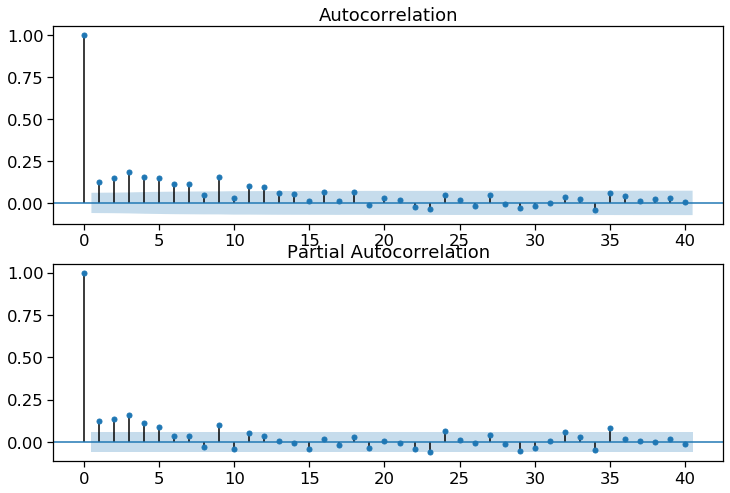

In [102]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(newNotes_discrete, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(newNotes_discrete, lags=40, ax=ax2)

## HMM - Continuous Emission

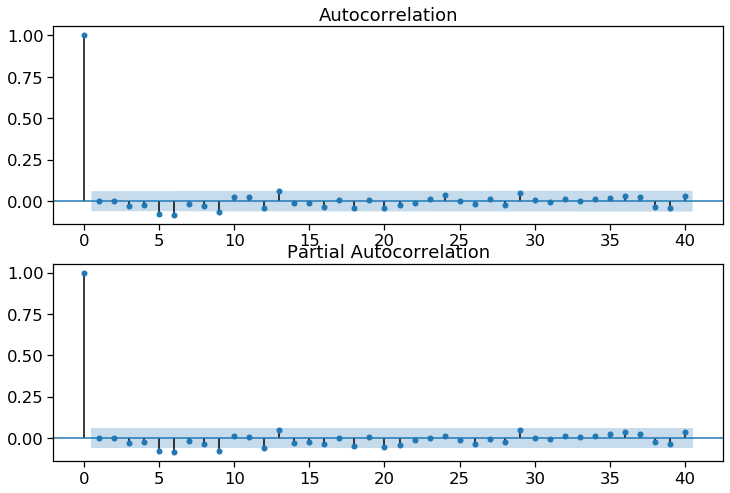

In [103]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(newNotes_cont, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(newNotes_cont, lags=40, ax=ax2)

## Kalman - ML

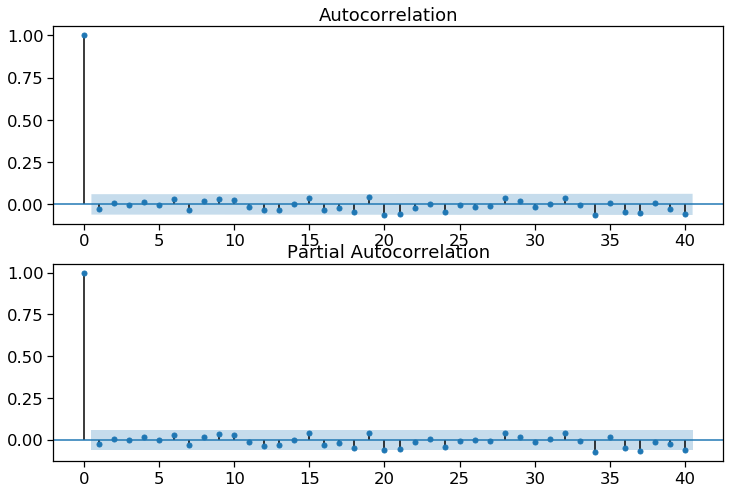

In [104]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(newNotes_KML, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(newNotes_KML, lags=40, ax=ax2)

## Kalman - Gibbs

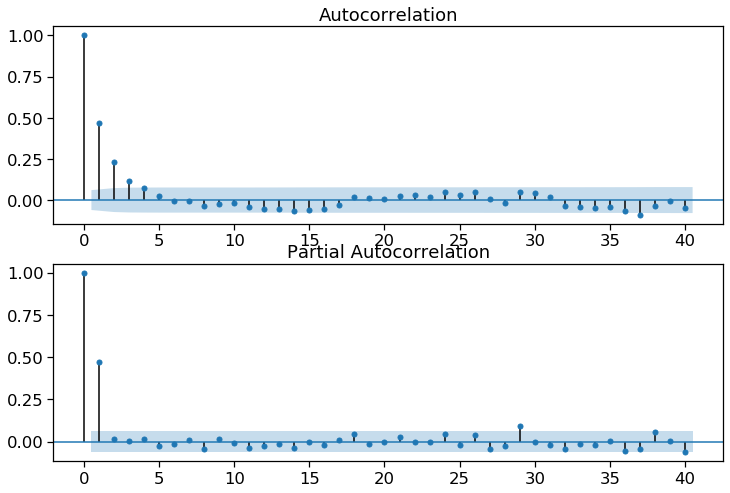

In [105]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(newNotes_K, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(newNotes_K, lags=40, ax=ax2)

## Dilated Convolutions

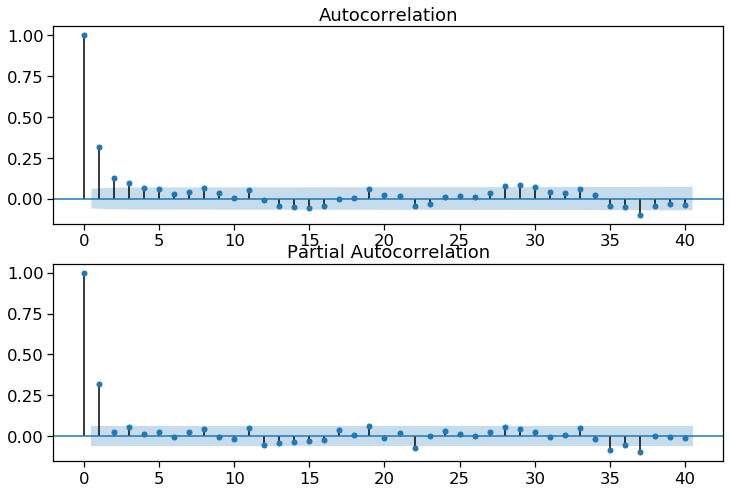

In [106]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(newNotes_dil, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(newNotes_dil, lags=40, ax=ax2)

- Dilated convolutions showing some persistence in ACF/PACF, still not a ton

## Latent Space

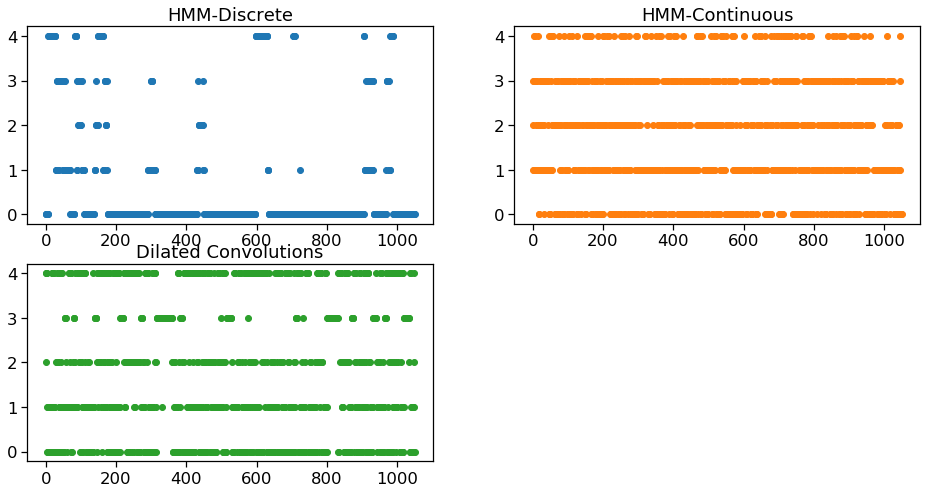

In [126]:
plt.figure(figsize = (16,8))
plt.subplot(2,2,1)
plt.scatter(np.arange(T), z_discrete, label = "HMM-Discrete")
plt.title("HMM-Discrete")
plt.subplot(2,2,2)
plt.title("HMM-Continuous")
plt.scatter(np.arange(T), z_cont, label = "HMM-Continuous", color = "C1")
plt.subplot(2,2,3)
plt.scatter(np.arange(T), z_dil, label = "Dilated Convolutions", color = "C2")
plt.title("Dilated Convolutions")

pass

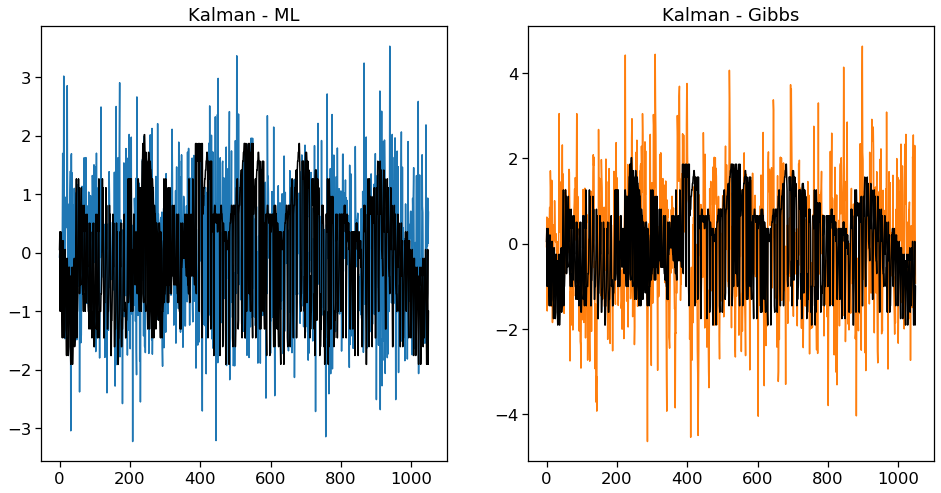

In [131]:
plt.figure(figsize = (16,8))
plt.subplot(1,2,1)
plt.plot(z_KML, label = "HMM-Discrete")
plt.plot(x, color = "black")
plt.title("Kalman - ML")
plt.subplot(1,2,2)
plt.title("Kalman - Gibbs")
plt.plot(z_K, label = "HMM-Continuous", color = "C1")
plt.plot(x, color = "black")
pass

## Parameter Analysis

In [143]:
np.unique(notes)

array([38, 42, 43, 45, 47, 49, 50, 52, 54, 55, 57, 59, 61, 62, 64, 66, 67,
       69, 71, 72, 73, 74, 76, 78, 79, 81, 83])

In [168]:
## Convert midi note pitches to note names
# Print with sharps or flats?
def midi_to_notenames(notes, sharp = True):
    if sharp:
        note_list = ['']*21 + ['A0','A#0', 'B0'] 
        note_list = note_list + [s + '1' for s in ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']] 
        note_list = note_list + [s + '2' for s in ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']] 
        note_list = note_list + [s + '3' for s in ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']] 
        note_list = note_list + [s + '4' for s in ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']] 
        note_list = note_list + [s + '5' for s in ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']] 
        note_list = note_list + [s + '6' for s in ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']] 
        note_list = note_list + [s + '7' for s in ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']]
    else:
        note_list = ['']*21 + ['A0','Bb0', 'B0'] 
        note_list = note_list + [s + '1' for s in ['C', 'Db', 'D', 'Eb', 'E', 'F', 'Gb', 'G', 'Ab', 'A', 'Bb', 'B']] 
        note_list = note_list + [s + '2' for s in ['C', 'Db', 'D', 'Eb', 'E', 'F', 'Gb', 'G', 'Ab', 'A', 'Bb', 'B']] 
        note_list = note_list + [s + '3' for s in ['C', 'Db', 'D', 'Eb', 'E', 'F', 'Gb', 'G', 'Ab', 'A', 'Bb', 'B']] 
        note_list = note_list + [s + '4' for s in ['C', 'Db', 'D', 'Eb', 'E', 'F', 'Gb', 'G', 'Ab', 'A', 'Bb', 'B']] 
        note_list = note_list + [s + '5' for s in ['C', 'Db', 'D', 'Eb', 'E', 'F', 'Gb', 'G', 'Ab', 'A', 'Bb', 'B']] 
        note_list = note_list + [s + '6' for s in ['C', 'Db', 'D', 'Eb', 'E', 'F', 'Gb', 'G', 'Ab', 'A', 'Bb', 'B']] 
        note_list = note_list + [s + '7' for s in ['C', 'Db', 'D', 'Eb', 'E', 'F', 'Gb', 'G', 'Ab', 'A', 'Bb', 'B']] 
    return(np.array(note_list)[np.unique(notes)])
    

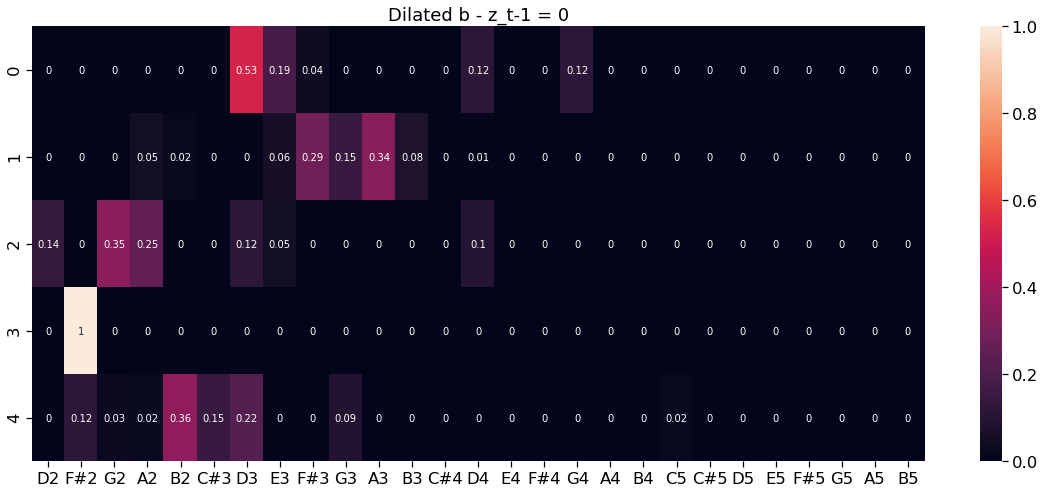

In [174]:
plt.figure(figsize = (20,8))
plt.title('Dilated b - z_t-1 = 0')
dil0 = pd.DataFrame(np.round(b[0,:,:], 2))
dil0.columns = midi_to_notenames(np.unique(notes).astype(int))
axs = sns.heatmap(dil0, annot=True)

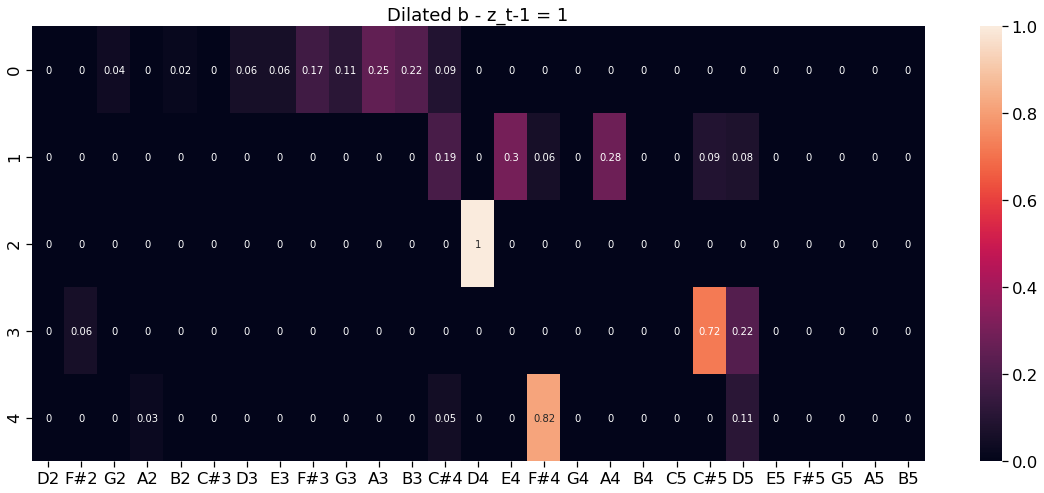

In [173]:
plt.figure(figsize = (20,8))
plt.title('Dilated b - z_t-1 = 1')
dil1 = pd.DataFrame(np.round(b[1,:,:], 2))
dil1.columns = midi_to_notenames(np.unique(notes).astype(int))
axs = sns.heatmap(dil1, annot=True)

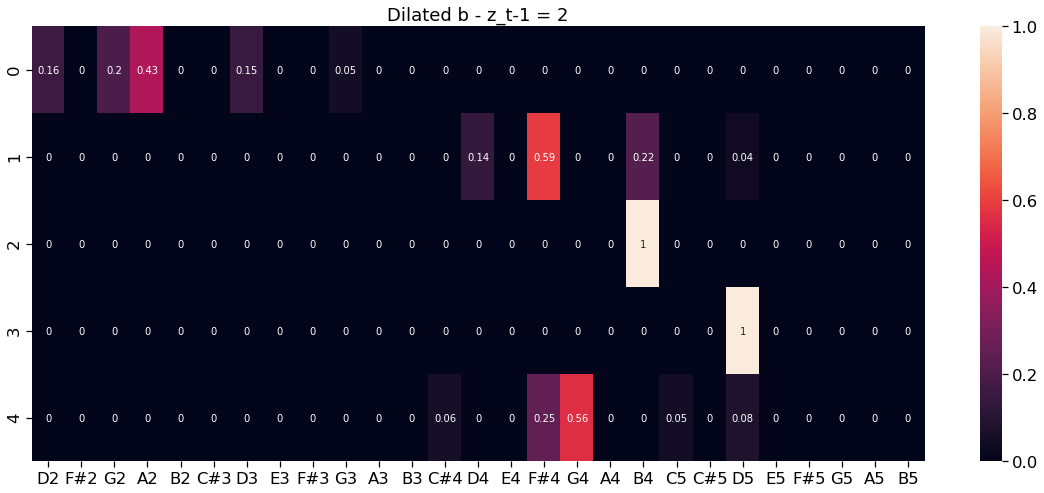

In [175]:
plt.figure(figsize = (20,8))
plt.title('Dilated b - z_t-1 = 2')
dil2 = pd.DataFrame(np.round(b[2,:,:], 2))
dil2.columns = midi_to_notenames(np.unique(notes).astype(int))
axs = sns.heatmap(dil2, annot=True)

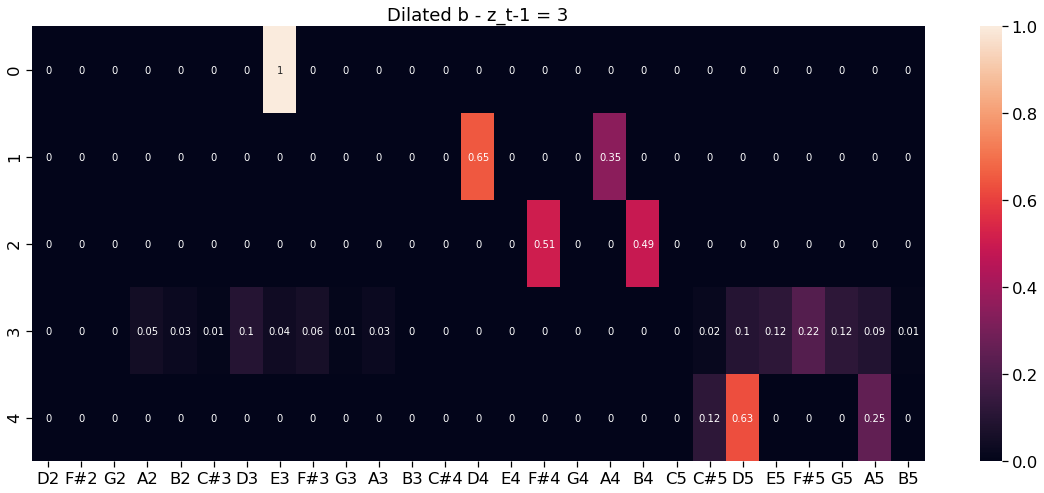

In [176]:
plt.figure(figsize = (20,8))
plt.title('Dilated b - z_t-1 = 3')
dil3 = pd.DataFrame(np.round(b[3,:,:], 2))
dil3.columns = midi_to_notenames(np.unique(notes).astype(int))
axs = sns.heatmap(dil3, annot=True)

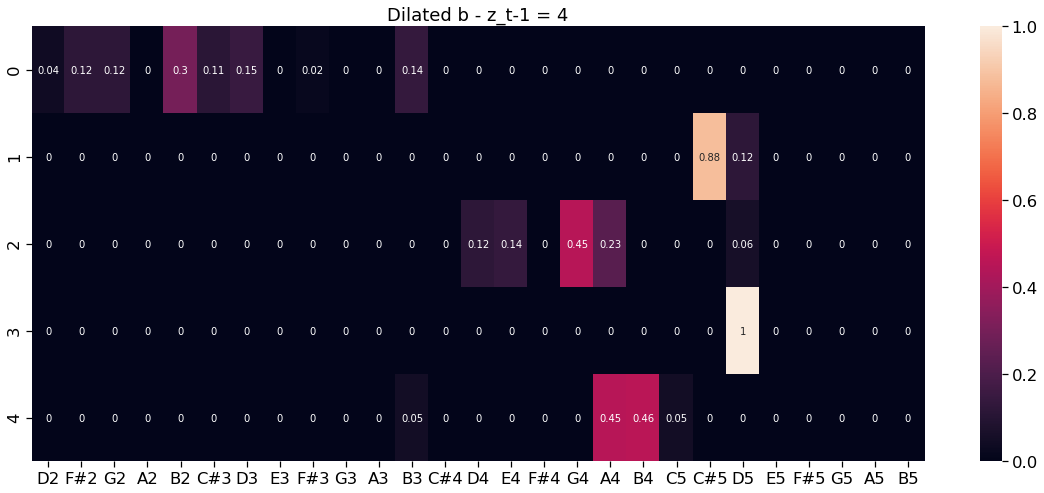

In [177]:
plt.figure(figsize = (20,8))
plt.title('Dilated b - z_t-1 = 4')
dil4 = pd.DataFrame(np.round(b[4,:,:], 2))
dil4.columns = midi_to_notenames(np.unique(notes).astype(int))
axs = sns.heatmap(dil4, annot=True)

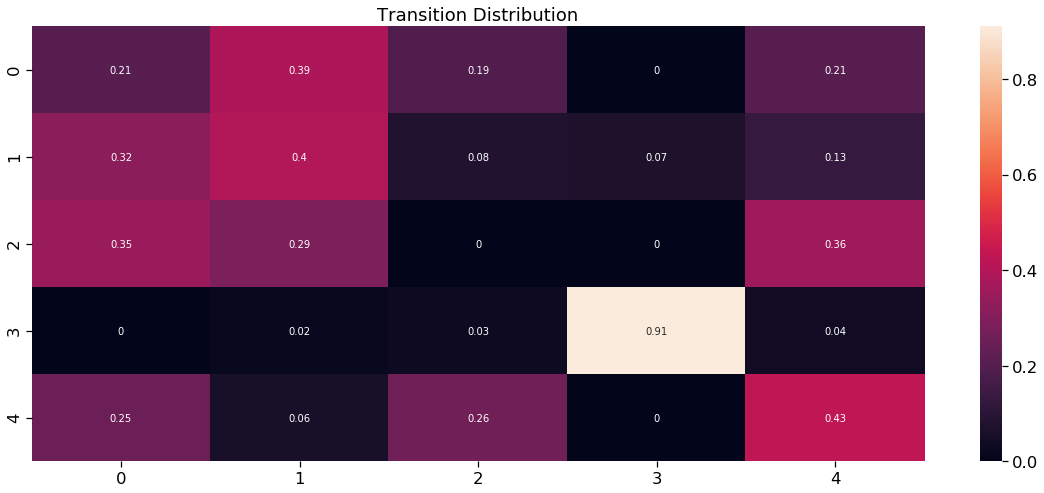

In [179]:
plt.figure(figsize = (20,8))
plt.title('Transition Distribution')
dil1 = pd.DataFrame(np.round(A, 2))
axs = sns.heatmap(dil1, annot=True)